# TUTORIAL 5 - TRAINING SPIKING NEURAL NETWORKS

In this tutorial, we will train a Spiking Neural Network (SNN) on the MNIST dataset. We will discuss the limitation of training SNNs and how to overcome them using surrogate gradients. 

In [1]:
# Imports

import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import itertools

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## THE NON-DIFFERENTIABLE OF SPIKES
Because the membrane potential is affected by previous spikes, SNNs resemble recurrent neural networks (RNNs). However, the non-differentiable nature of spikes makes training SNNs more challenging.

$$\begin{align*}
    U[t+1] = \beta U[t] + WX[t+1]-R[t]
\end{align*}$$

Where $R[t]$ is the reset mechnism, that defaults to substraction (subtratcting the threshold $U_{th}$)

$$\begin{align*}
    S[t] = \begin{cases}
        1 & \text{if } U[t] > U_{th} \\
        0 & \text{o.w.}
    \end{cases}
\end{align*}$$

$S[t]$ can be represeted as the derivative of the Heaviside step function, which is not differentiable. 
$$\begin{align*}
    S[t] = \Theta(U[t] - U_{th}) 
\end{align*}$$

The derivative of the Heaviside step function equals infinity at the threshold, and zero otherwise - the Dirac Delta function. Because we take the derivative during backpropagation step (chain rule), the gradient of the loss function is zero everywhere except at the threshold, where it is infinite. This means that no learning can take place. To solve this problem, we are going to make a small modification: during the `forward pass`, we will use the Heaviside step function, but during the `backward pass`, we will approximate the step function with a continuous function that has a non-zero derivative everywhere. This is called a *surrogate function*. It works pretty well in practice, and we will use it in this tutorial.

An example of a surrogate function is $\arctan$, with the following derivative:
$$\begin{align*}
    \frac{d}{dx} \arctan(x) = \frac{1}{1+x^2}
\end{align*}$$

In [2]:
class LeakySurrogate(nn.Module):
    """
    A surrogate function for the Heaviside step function.
    It is used to approximate the step function during backpropagation.

    Arguments:
        beta (float): Decay rate of the surrogate function.
        threshold (float): Threshold value for the surrogate function.
            Default is 1.0.
    """

    def __init__(self, beta, threshold=1.0):
        super(LeakySurrogate, self).__init__()
        
        # initialize decay rate and threshold
        self.beta = beta #torch.tensor(beta, requires_grad=False, device=device)
        self.threshold = threshold

        self.spike_gradient = self.ATan.apply   # We are going to rewrite the arctan function of pytorch

    def init_leaky(self, batch_size, num_neurons):
        return torch.zeros((batch_size, num_neurons), dtype=dtype).to(device)

    def forward(self, input_, mem):
        """Called each time we call LeakySurrogate"""

        spk = self.spike_gradient((mem-self.threshold))
        reset = (self.beta*spk*self.threshold).detach()     # Remove reset from computation graph
        mem = self.beta * mem + input_ - reset
        return spk, mem

    # Now lets rewrite the forward and backward methods of arctan
    # Forward pass: Heaviside step function
    # Backward pass: Override Dirac Delta function with derivative of arctan function
    
    @staticmethod
    class ATan(torch.autograd.Function):
        @staticmethod
        def forward(ctx, mem):
            spk = (mem > 0).float()         # Heaviside on the forward pass
            ctx.save_for_backward(mem)      # Store the membrane for use in the backward pass
            return spk
        
        @staticmethod
        def backward(ctx, grad_output):
            (mem, ) = ctx.saved_tensors   # Retrieve the stored membrane potential
            # Use torch.pi for device compatibility and multiply by grad_output
            grad = 1/(1 + (torch.pi * mem).pow(2)) * grad_output
            return grad



Now lets instansiate the leaky neuron model with the surrogate function. 

In [3]:
lif1 = LeakySurrogate(beta=0.9)
lif1.to(device)


LeakySurrogate()

## SETTING UP THE STATIC MNIST DATASET

In [4]:
# datalader arguments
batch_size = 128
data_path = '/tmp/data/mnist'

In [5]:
# Deine input transforms
transform = transforms.Compose([
    transforms.Resize((28, 28)),        # Resize images to 28x28
    transforms.Grayscale(),             # Convert images to grayscale
    transforms.ToTensor(),              # Convert images to tensors
    transforms.Normalize((0.,), (1.,))  # Normalize images to [0, 1]
])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

In [6]:
# Create Dataloaders
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, drop_last=True)

## DEFINE THE NETWORK

In [7]:
num_inputs = 28*28      # flattened size of MNIST images
num_hidden = 1000
num_outputs = 10        # 10 classes for MNIST

# Temporal Dynamics
num_steps = 25          # Num of time steps in each spamle
beta = 0.95

In [8]:
# Define the SNN network
class SNNnet(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = LeakySurrogate(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = LeakySurrogate(beta=beta)

    def forward(self, x):

        # Init membrane potentials
        mem1 = self.lif1.init_leaky(x.shape[0], self.fc1.out_features)   # set membrane potential to 0       
        mem2 = self.lif2.init_leaky(x.shape[0], self.fc2.out_features)   # set membrane potential to 0

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # stimulate the network for a time window (num of steps)
        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            
            # record the spikes and membrane potential
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)
    
# Load the network
net = SNNnet().to(device)

## LOSS DEFINITION
We are going to use softmax on the output membrane potential, followed by cross entropy loss - the correct neuron representing the class should have the highest potential. Using `torch.nn.CrossEntropyLoss` will take care of the softmax and the loss calculation for us. 

In [9]:
loss = nn.CrossEntropyLoss()

## OPTIMIZER

Adam is a robust optimizer that performs wee on recurrent networks, so let's use that with a learning rate of $5 \times 10^{-4}$

In [10]:
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))  # Use beta values for Adam optimizer

## ACCURACY METRIC

Below are functions that take a batch of data, counts up all the spikes from each neruon (equivilent to rate code over sim time), and compares the index of the highes count with actual target.

In [11]:
# Pass the data into the network, sum spikes over time.
# Compare the neuro with the hgiest number of spikes with the target.


def get_batch_accuracy(net_output, targets):
    num_spikes = net_output.sum(dim=0)  # Sum spikes over time
    _, predicted_idx = torch.max(num_spikes, 1)  # Get the index of the max
    acc = np.mean((targets == predicted_idx).detach().cpu().numpy())

    return acc

## SANITY TESTS
Lets load the first batch of data, load it onto CUDA and check that we understand the sizes

In [12]:
data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

# Now lets run a single pass through the network.
# Important - this is a fully connected nn (not conv), so we need to flatten the input data

spk_rec, mem_rec = net(data.view(batch_size, -1))

print("Spikes shape [Time_Steps, Samples_of_Data, Labels]:", spk_rec.shape)
print("Membrane shape [Time_Steps, Samples_of_Data, Labels]:", mem_rec.shape)

Spikes shape [Time_Steps, Samples_of_Data, Labels]: torch.Size([25, 128, 10])
Membrane shape [Time_Steps, Samples_of_Data, Labels]: torch.Size([25, 128, 10])


We got:
* 25 Time Steps
* 128 Samples of Data
* 10 Labels

Now lets see what the loss on the dataset is, using the network we defined above.

In [13]:
# init validation loss
train_loss = torch.zeros(1, dtype=dtype).to(device)

# This is the validation loss, taken over the first batch of data, over time_steps of the time window.
for step in range(num_steps):
    train_loss += loss(mem_rec[step], targets)        # Validation loss is computed over the membrane potential

print(f"Train Loss: {train_loss.item()}")
print(f"Train Accuracy: {get_batch_accuracy(spk_rec, targets)*100:.2f}%")

Train Loss: 59.53377914428711
Train Accuracy: 8.59%


The train loss is summed over all time steps. In correspondance, the accuracy is also low. This is because the network is not trained yet.

Now lets run a single backward pass, update the weights and check the loss and accuracy again.

In [14]:
# First, init the optimizer to remove all previous gradients
optimizer.zero_grad()

# Calculate the gradients
train_loss.backward()

# Update the weights
optimizer.step()

Now lets compute the loss again, on the same batch of data.

In [15]:
spk_rec, mem_rec = net(data.view(batch_size, -1))

# initiazlize the loss
train_loss = torch.zeros(1, dtype=dtype).to(device)

for step in range(num_steps):
    train_loss += loss(mem_rec[step], targets)        # Validation loss is computed over the membrane potential

print(f"Train Loss: {train_loss.item()}")
print(f"Train Accuracy: {get_batch_accuracy(spk_rec, targets)*100:.2f}%")

Train Loss: 49.849945068359375
Train Accuracy: 49.22%


The accuracy has increased from 7.81% to 11.72%. 

# FULL TRAINING LOOP
Now lets run the training again and see what happens to the loss and accuracy. We are going to train the network for 10 epochs, and save the loss and accuracy at each epoch.

In [16]:
num_epochs = 5
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

for epoch in range(num_epochs):
    net.train()
    counter = 0
    for data, targets in train_loader:
        data = data.to(device)
        targets = targets.to(device)

        # Forward pass
        spk_rec, mem_rec = net(data.view(batch_size, -1))   # Shape is [Time_Steps, Samples_of_Data, Labels]

        # Go through all time steps. 
        # For each time step, calculate the loss and accuracy
        # The loss is calculated over the membrane potential
        # The accuracy is calculated over the spikes

        train_loss = torch.zeros(1, dtype=dtype).to(device)  # Reset the loss for each batch
        for step in range(num_steps):
            train_loss += loss(mem_rec[step], targets)       # The membrane potential should be highest for the correct class
            
        # batch accuracy
        acc = get_batch_accuracy(spk_rec, targets)
        train_loss_history.append(train_loss.item())
        train_acc_history.append(acc)   # Train accuracy per batch
        
        if counter % 100 == 0:
            # Print the loss and accuracy every 100 batches
            print(f"Train \t Epoch {epoch+1}/{num_epochs},\t Loss: {train_loss.item():.4f}, \t Accuracy: {acc*100:.2f}%")


        # Gradient calculation + weight update
        optimizer.zero_grad()  # Zero the gradients before the backward pass
        train_loss.backward()
        optimizer.step()  # Update the weights

        counter += 1
    
    # After each epoch, we can validate the model on the test set
    net.eval()
    with torch.no_grad():
        val_loss = torch.zeros(1, dtype=dtype).to(device)
        val_acc = []

        for data, targets in test_loader:
            data = data.to(device)
            targets = targets.to(device)

            spk_rec, mem_rec = net(data.view(batch_size, -1))

            batch_val_loss = torch.zeros(1, dtype=dtype).to(device)
            for step in range(num_steps):
                batch_val_loss += loss(mem_rec[step], targets)

            batch_val_loss /= len(test_loader)
            batch_val_acc = get_batch_accuracy(spk_rec, targets)

            val_loss += batch_val_loss
            val_acc_history.append(batch_val_acc)

            val_loss_history.append(batch_val_loss.item())  # Average loss over the test set


        print(f"Val \t Epoch {epoch+1}/{num_epochs},\t Loss: {val_loss.item():.4f}, \t Accuracy: {np.mean(val_acc_history)*100:.2f}%")

Train 	 Epoch 1/5,	 Loss: 52.0162, 	 Accuracy: 38.28%
Train 	 Epoch 1/5,	 Loss: 16.3981, 	 Accuracy: 85.94%
Train 	 Epoch 1/5,	 Loss: 12.4962, 	 Accuracy: 93.75%
Train 	 Epoch 1/5,	 Loss: 10.9013, 	 Accuracy: 88.28%
Train 	 Epoch 1/5,	 Loss: 8.7128, 	 Accuracy: 95.31%
Val 	 Epoch 1/5,	 Loss: 8.0983, 	 Accuracy: 93.43%
Train 	 Epoch 2/5,	 Loss: 9.4152, 	 Accuracy: 96.09%
Train 	 Epoch 2/5,	 Loss: 7.9613, 	 Accuracy: 96.88%
Train 	 Epoch 2/5,	 Loss: 8.1835, 	 Accuracy: 92.19%
Train 	 Epoch 2/5,	 Loss: 7.5594, 	 Accuracy: 93.75%
Train 	 Epoch 2/5,	 Loss: 5.5711, 	 Accuracy: 98.44%
Val 	 Epoch 2/5,	 Loss: 6.4864, 	 Accuracy: 94.58%
Train 	 Epoch 3/5,	 Loss: 4.9659, 	 Accuracy: 100.00%
Train 	 Epoch 3/5,	 Loss: 7.6960, 	 Accuracy: 92.19%
Train 	 Epoch 3/5,	 Loss: 4.8679, 	 Accuracy: 94.53%
Train 	 Epoch 3/5,	 Loss: 4.5569, 	 Accuracy: 99.22%
Train 	 Epoch 3/5,	 Loss: 5.2795, 	 Accuracy: 96.09%
Val 	 Epoch 3/5,	 Loss: 5.9086, 	 Accuracy: 94.99%
Train 	 Epoch 4/5,	 Loss: 4.8523, 	 Accuracy: 9

# PLOTTING THE RESULTS
Now lets plot the loss and accuracy over the epochs.

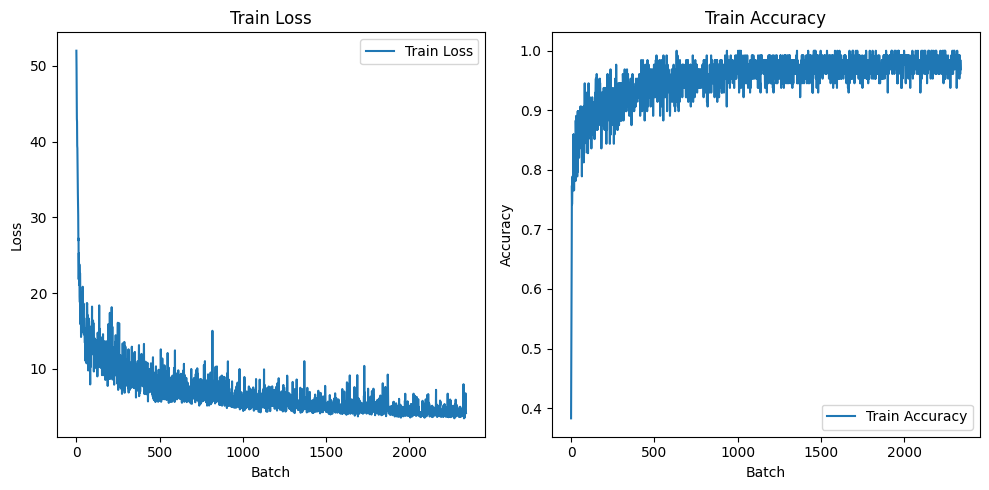

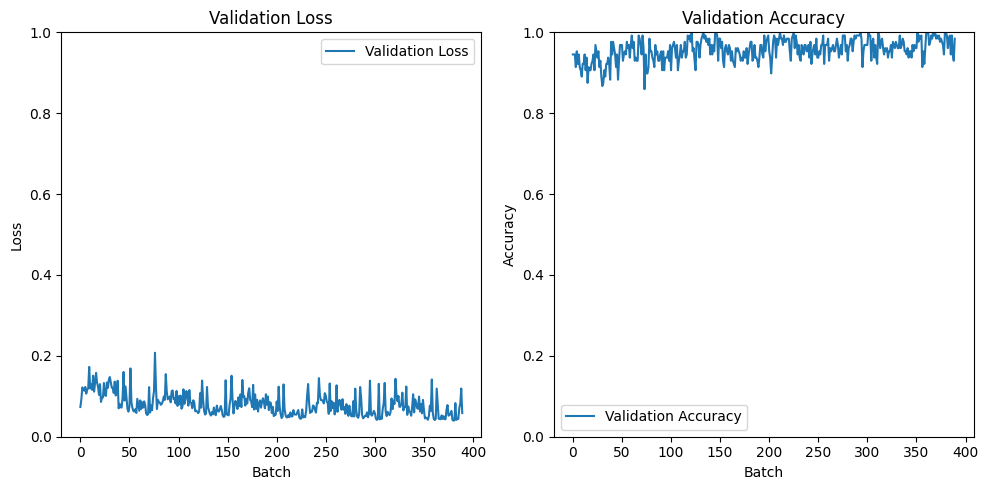

In [24]:
# Plott loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Train Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Accuracy')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.title('Train Accuracy')
plt.legend()

plt.tight_layout()

# Plot validation loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.ylim(0, 1)  # Set y-axis limit for accuracy
plt.title('Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_acc_history, label='Validation Accuracy')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.ylim(0, 1)  # Set y-axis limit for accuracy
plt.tight_layout()
plt.show()
